# **Model comparison**
####Team:

  - Diego Ordonez Pasaje
  - Maria Rossano
  - Tanwi Sarkar


####Name of Data Set:
  - Polycystic ovary syndrome (PCOS) 

In [ ]:
# To do an analysis with shap first install shap:
!pip install shap

In [ ]:
import math
from time import time

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVC

from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import shap
shap.initjs()

import joblib

from google.colab import drive
drive.mount('/content/drive')

**Load Data**

In [ ]:
PCOS_path = "../Datasets/"

PCOS_file = PCOS_path + "PCOS_data_without_infertility.xlsx"
PCOS = pd.read_excel(PCOS_file, sheet_name="Full_new")

# **Balance of data**

In [ ]:
# This is a code for the pie chart:
df_group = PCOS['PCOS (Y/N)']
values = PCOS['PCOS (Y/N)'].value_counts()
names = ["No", "Yes"]
fig = px.pie(df_group, values=values, names=names, title='Proportion of PCOS')
fig.update_layout(title_font_size=32)
fig.update_traces(textfont_size=30, marker=dict(line=dict(width=2)))
fig.update_layout(
    legend=dict(
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=0.3),
    title=dict(
        y=0.98,
        x=0.3
        
    )
)
fig.show()

# **0. Data Transformation and Feature Engineering**

In [ ]:
# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 1. Drop non-features/labels columns and misaligned column**
# columns to be droped
columns_drop =['Sl. No', 'Patient File No.', \
                'Unnamed: 44']

# labels name
# JUST FOR DATA TRANSFORMATION, VARIABLE WILL BE REDIRECTED LATER:
labels_name ='PCOS (Y/N)' 

# 1. Drop columns in `not_to_be_used`
PCOS.drop(columns_drop, axis=1, inplace=True)

# Check
display(PCOS.head())
display(PCOS.tail())

# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 2. Address non float values**
### Feature 'AMH(ng/mL)' has a none float64 value in row: `305`
### Feature 'II    beta-HCG(mIU/mL)' has a none float64 value in row: `123`

# 2.  Address non float values in rows [305, 123].
# A. 
# Rest of values in PCOS.iloc[305] seem to be consistent w/neighbouring rows
#PCOS.iloc[[301, 302, 303, 304, 305]].T

# Thus, I suggest converting their value "a" into a nan
# and treat it as a missing value.
PCOS.replace(PCOS['AMH(ng/mL)'].iloc[305], np.nan, inplace=True)
PCOS['AMH(ng/mL)'] = pd.to_numeric(PCOS['AMH(ng/mL)'], errors = 'coerce')

# B.
# PCOS.iloc[[123, 124, 125]].T
# Seems to be an extra "." in the feature value "1.99.".
# Check with `PCOS['II    beta-HCG(mIU/mL)'].iloc[120:125].T`
PCOS.replace(PCOS['II    beta-HCG(mIU/mL)'].iloc[123], float(1.99), \
             inplace=True)
PCOS['II    beta-HCG(mIU/mL)'] = pd.to_numeric(PCOS['II    beta-HCG(mIU/mL)'],\
                                               errors='coerce')


# Check dtypes
PCOS.dtypes

# Check those specific feature values
print(f"\n305: {PCOS['AMH(ng/mL)'].iloc[305]}")
print(f"123: {PCOS['II    beta-HCG(mIU/mL)'].iloc[123]}\n")

# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 3. Drop outliers (i.e., rows with outliers)**

# 3. Drop outliers (i.e, rows with outliers):
rows_drop_dict = {"Pulse":[223, 296],
                  "BP_Systolic": [161], 
                  "BP_Diastolic": [200]}

drops = []
for val in rows_drop_dict.values():
  drops += val

PCOS.drop(drops, axis=0, inplace=True)


# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 4. Reindex**
# Reset index of df
PCOS.reset_index(drop=True, inplace=True)

PCOS.columns

PCOS (Y/N)   Age (yrs)  Weight (Kg)  Height(Cm)         BMI  Blood Group  \
0         0.0        28.0         44.6        152.0  19.300000         15.0   
1         0.0        36.0         65.0        161.5  24.921163         15.0   
2         1.0        33.0         68.8        165.0  25.270891         11.0   
3         0.0        37.0         65.0        148.0  29.674945         13.0   
4         0.0        25.0         52.0        161.0  20.060954         11.0   

   Pulse rate(bpm)   RR (breaths/min)  Hb(g/dl)  Cycle(R/I)  ...  \
0              78.0              22.0     10.48         2.0  ...   
1              74.0              20.0     11.70         2.0  ...   
2              72.0              18.0     11.80         2.0  ...   
3              72.0              20.0     12.00         2.0  ...   
4              72.0              18.0     10.00         2.0  ...   

   Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0           0.0              1.0                0.0                110.0   
1           0.0              0.0                0.0                120.0   
2           1.0              1.0                0.0                120.0   
3           0.0              0.0                0.0                120.0   
4           0.0              0.0                0.0                120.0   

   BP _Diastolic (mmHg) Follicle No. (L)  Follicle No. (R)  \
0                  80.0              3.0               3.0   
1                  70.0              3.0               5.0   
2                  80.0             13.0              15.0   
3                  70.0              2.0               2.0   
4                  80.0              3.0               4.0   

   Avg. F size (L) (mm)  Avg. F size (R) (mm)  Endometrium (mm)  
0                  18.0                  18.0               8.5  
1                  15.0                  14.0               3.7  
2                  18.0                  20.0              10.0  
3                  15.0                  14.0               7.5  
4                  16.0                  14.0               7.0  

[5 rows x 42 columns]

PCOS (Y/N)   Age (yrs)  Weight (Kg)  Height(Cm)    BMI  Blood Group  \
536         0.0        35.0         50.0      164.592  18.5         17.0   
537         0.0        30.0         63.2      158.000  25.3         15.0   
538         0.0        36.0         54.0      152.000  23.4         13.0   
539         0.0        27.0         50.0      150.000  22.2         15.0   
540         1.0        23.0         82.0      165.000  30.1         13.0   

     Pulse rate(bpm)   RR (breaths/min)  Hb(g/dl)  Cycle(R/I)  ...  \
536              72.0              16.0      11.0         2.0  ...   
537              72.0              18.0      10.8         2.0  ...   
538              74.0              20.0      10.8         2.0  ...   
539              74.0              20.0      12.0         4.0  ...   
540              80.0              20.0      10.2         4.0  ...   

     Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
536           0.0              0.0                0.0                110.0   
537           0.0              0.0                0.0                110.0   
538           0.0              0.0                0.0                110.0   
539           1.0              0.0                0.0                110.0   
540           1.0              1.0                0.0                120.0   

     BP _Diastolic (mmHg) Follicle No. (L)  Follicle No. (R)  \
536                  70.0              1.0               0.0   
537                  70.0              9.0               7.0   
538                  80.0              1.0               0.0   
539                  70.0              7.0               6.0   
540                  70.0              9.0              10.0   

     Avg. F size (L) (mm)  Avg. F size (R) (mm)  Endometrium (mm)  
536                  17.5                  10.0               6.7  
537                  19.0                  18.0               8.2  
538                  18.0                   9.0               7.3  
539                  18.0                  16.0              11.5  
540                  19.0                  18.0               6.9  

[5 rows x 42 columns]


305: nan
123: 1.99



Index(['PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)', 'Height(Cm) ', 'BMI',
       'Blood Group', 'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)',
       'Cycle(R/I)', 'Cycle length(days)', 'Marraige Status (Yrs)',
       'Pregnant(Y/N)', 'No. of aborptions', '  I   beta-HCG(mIU/mL)',
       'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH',
       'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio', 'TSH (mIU/L)',
       'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)',
       'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)'],
      dtype='object')

## **Feature Enconding**

In [ ]:
# Create feature labels of encoded features
features_categ_encode = ['Blood Group', 'Cycle(R/I)']
features_categ_rename = ['Blood_Group', 'Cycle(R/I)']
features_categ_rename = ["enc_" + feature.lower() for feature in features_categ_rename]


PCOS = pd.get_dummies(PCOS, columns=features_categ_encode, prefix=features_categ_rename)

## **Split Data**

In [ ]:
# Select data
pcos_clean_columns = PCOS.columns
X = PCOS[pcos_clean_columns[1:]]
y = PCOS[labels_name]

# Split data in training, validation and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=23)
# y_train.head()

## **Feature transfomartion across rows and columns**

In [ ]:
X_data_list = [X_train, X_val, X_test]
# ----------------------------------------------------------
# ----------------------------------------------------------
## **STEP 6. filling `Nan`'s values for specific rows**
# 305, 458, 156

# A. PCOS.iloc[[ 458]].T has a Nan value for the 'Marraige Status (Yrs)'
# This woman (PCOS.iloc[[ 458]]) has 36 year old
# So, we calculate the mean of 'Marraige Status (Yrs)' for those that only have 36 year old
# Then, we use this mean to fill the Nan value: 

# data points of women with 36 year all and their respective years of marriege:

for X_data in X_data_list:
  age36Marraige = X_data[X_data[' Age (yrs)']==36]['Marraige Status (Yrs)']
  age36Marraige_mean = age36Marraige.mean() 
  X_data['Marraige Status (Yrs)'].fillna(age36Marraige_mean, inplace=True)

  # B. PCOS.iloc[[ 156]].T has a Nan value for the 'Fast food (Y/N)'
  # We fill this value with the mode of 'Fast food (Y/N)':

  X_data['Fast food (Y/N)'].fillna(X_data['Fast food (Y/N)'].mode()[0], inplace=True)

  # C. PCOS.iloc[[ 305]].T has a Nan value for the feature "AMH(ng/mL)"
  mean_amh = X_data["AMH(ng/mL)"].mean()
  X_data["AMH(ng/mL)"].fillna(mean_amh, inplace=True)



  # ----------------------------------------------------------
  # ----------------------------------------------------------
  ## **STEP 7. Recalculate BMI and drop `BMI` column**
  # Recalculate BMI
  def get_bmi(row):
    w = row["Weight (Kg)"]
    h = float(row["Height(Cm) "])/100
    bmi = w/h**2
    return bmi

  # Create a column with the recalculated BMI
  X_data["bmi_recalc"] = X_data.apply(get_bmi, axis=1)

  # Drop column
  X_data.drop("BMI", axis=1, inplace=True)

  # ----------------------------------------------------------
  # ----------------------------------------------------------
  ## **STEP 8. Aggregate Follicle L and R, i.e., get total number of follicles**
  def get_TotalFollicles(row):
    r = row['Follicle No. (L)']
    l = row['Follicle No. (R)']
    tf = r+l 
    return tf
    
  X_data['Total No of Folicles'] = X_data.apply(get_TotalFollicles, axis=1)
  X_data.drop(['Follicle No. (R)', 'Follicle No. (L)'], axis=1, inplace=True)

  # ----------------------------------------------------------
  # ----------------------------------------------------------
  ## **STEP 9. Aggregate Avg. F size (L) and (R), i.e., get average follicles' size**

  def get_TotalAverageFollicles(row):
    ra = row['Avg. F size (L) (mm)']
    la = row['Avg. F size (R) (mm)']
    tfa = (ra+la)/2
    return tfa
    
  X_data['Average size of Folicles (mm)'] = \
  X_data.apply(get_TotalAverageFollicles, axis=1)

  X_data.drop(['Avg. F size (L) (mm)', 'Avg. F size (R) (mm)'], \
            axis=1, inplace=True)

  # ----------------------------------------------------------
  # ----------------------------------------------------------
  ## **STEP 10. Get Mean Arterial Pressure
  ## get average follicles' size**

  def get_MeanArterialPreassure(row):
    d = row['BP _Diastolic (mmHg)']
    s = row['BP _Systolic (mmHg)']
    map = (2*d+s)/3 
    return map
    
  X_data["Mean_Arterial_Preassure"] = X_data.apply(get_MeanArterialPreassure, axis=1)

  # ----------------------------------------------------------
  # ----------------------------------------------------------
  # STEP 10. Categorize BMI
  def get_obe(row):
    """Categorize BMI into obsese or not obese.

    returns: bmi==1, bmi=0 
    """
    bmi = row["bmi_recalc"]
    if bmi >= 25:
      bmi = 1
    else:
      bmi = 0
    return bmi


  X_data["obesity_(y/n)"] = X_data.apply(get_obe, axis=1)

  # check columns

  print(f"Total of features + label: {len(X_data.columns)}")

Total of features + label: 50
Total of features + label: 50
Total of features + label: 50


# **Split features names**

In [ ]:
# Split feature names into two groups, categorical and numerical

columns_names = X_train.columns # either X_train or X_test is fine

features_categ = []
features_numeric = []

for column in columns_names:
  unq = X_train[column].unique()
  if column != labels_name:
    if len(unq) <= 3 or (column == "Blood Group"):
      features_categ.append(column)
    else:
      features_numeric.append(column)


features_all = features_categ + features_numeric


# **Address skewness**

In [ ]:
# Define functions to attenuate skewness
def get_recip(row):
  """Transform feature to atenuate skewness.
  
  Get reciprocal of feature value.
  """
  recip = 1/row
  return recip

# Define Square Function
def get_sqr(row):
  """Transform feature to atenuate skewness.
  
  Get square of feature value.
  """
  sqr = row**2
  return sqr

# Define Logarithm Function
def get_log(row):
  """Transform feature to atenuate skewness.
  
  Get log10 of feature value.
  """
  log = math.log(row)
  return log

In [ ]:
def get_best_skew(numeric_feats, x_data, skew_atens, colors):
  x_data_copy = x_data.copy()
  rows = len(features_numeric)
  
  # Get best transformation for each feature
  best_transform = {}

  fig = plt.figure(figsize=(35, rows*10))
  c=1
  for feature in features_numeric:
    print("Working on {} feature".format(feature))
    # Get skewness for untransformed feature
    skew_val_bef = x_data_copy[feature].skew()

    # Generate plots for transformed features
    labels = ["recip_" + feature, "sqr_" + feature, "log_" + feature]

    # Compare skewness' (part 1/2)
    method = "Original"
    overall_skewness = 0

    for aten_idx, aten in enumerate(skew_atens):
      # Create a column w/transformed feature
      new_feature = labels[aten_idx]

      try:
        x_data_copy[new_feature] = x_data_copy[feature].apply(aten)
      except ZeroDivisionError:
        print("--> Oops! It seems a 1/0 division got in the way.")
        x_data_copy[new_feature] = x_data_copy[feature]
      except ValueError:
        print("--> Oops! It seems a log10(0) got in the way.")
        x_data_copy[new_feature] = x_data_copy[feature]

      # Get skewness
      skew_val_af = x_data_copy[new_feature].skew()

      x_label = feature
      if skew_val_af == skew_val_bef:
        x_label = '"FAILED"'
      
      # Compare skewness' (part 2/2)
      if abs(skew_val_af) < abs(skew_val_bef):
        overall_skewness = skew_val_af
        method = type_trans[aten_idx]
      
      # Get histograms
      plt.subplot(rows, 3, c)
      plt.title("Transform: {}; Skewness (aft/bef): {:.2f}/{:.2f}".format(type_trans[aten_idx],\
                                                            skew_val_af, skew_val_bef), \
                fontsize=20)
      n, bins, patches = plt.hist(x_data_copy[new_feature], color=colors[aten_idx])
      # print(type(n), bins, patches)
      
      plt.xlim(left=np.amin(bins), right=np.amax(bins))
      plt.ylim(bottom=0, top=np.amax(n)+10)
      plt.xlabel(x_label, fontsize=20)
      plt.ylabel("Frequency", fontsize=20)
      plt.xticks(fontsize=12)
      plt.yticks(fontsize=12)
      plt.margins(2.0)
      c +=1

    # Append only those features for which a lower skewness was obtained
    if method != "Original":
      best_transform[feature]= method


  plt.show()
  return best_transform

### **Following lines will include skewness-------------->**

In [ ]:
# For plotting only:
_X_train_copy = X_train.copy()
_X_train_avfollicle = _X_train_copy["Average size of Folicles (mm)"]

Working on  Age (yrs) feature
Working on Weight (Kg) feature
Working on Height(Cm)  feature
Working on Pulse rate(bpm)  feature
Working on RR (breaths/min) feature
Working on Hb(g/dl) feature
Working on Cycle length(days) feature
--> Oops! It seems a 1/0 division got in the way.
--> Oops! It seems a log10(0) got in the way.
Working on Marraige Status (Yrs) feature
--> Oops! It seems a 1/0 division got in the way.
--> Oops! It seems a log10(0) got in the way.
Working on No. of aborptions feature
--> Oops! It seems a 1/0 division got in the way.
--> Oops! It seems a log10(0) got in the way.
Working on   I   beta-HCG(mIU/mL) feature
Working on II    beta-HCG(mIU/mL) feature
Working on FSH(mIU/mL) feature
Working on LH(mIU/mL) feature
Working on FSH/LH feature
Working on Hip(inch) feature
Working on Waist(inch) feature
Working on Waist:Hip Ratio feature
Working on TSH (mIU/L) feature
Working on AMH(ng/mL) feature
Working on PRL(ng/mL) feature
Working on Vit D3 (ng/mL) feature
--> Oops! It 

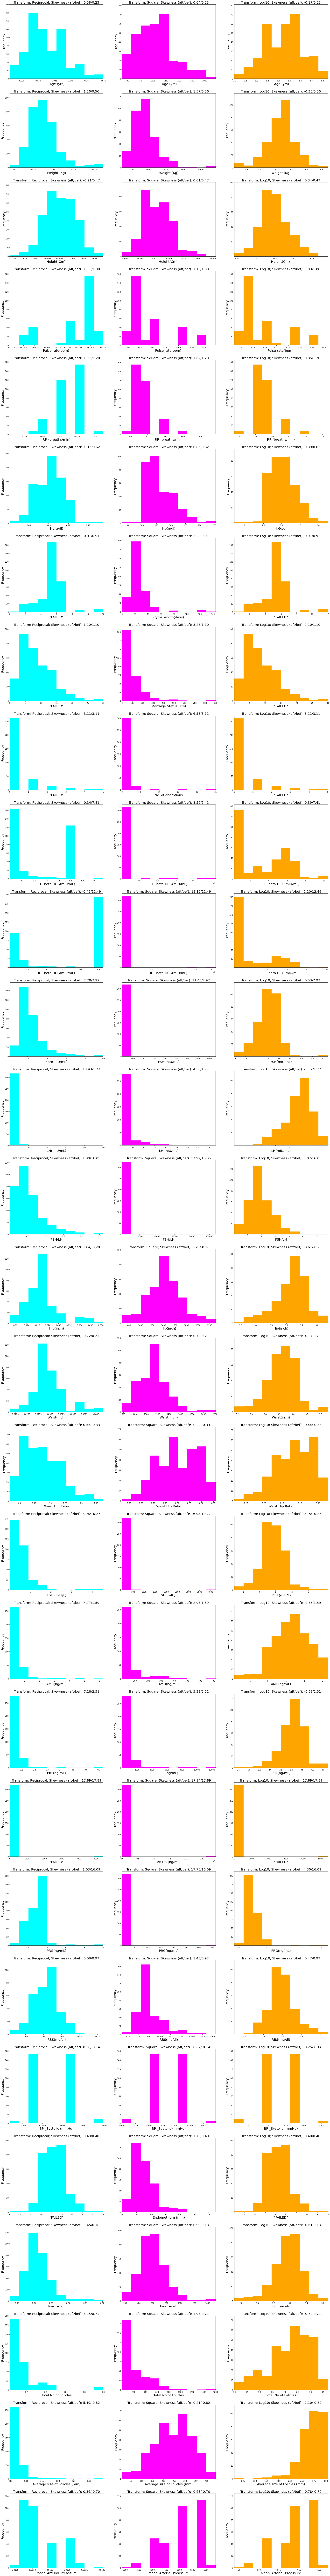

Working on  Age (yrs) feature
Working on Weight (Kg) feature
Working on Height(Cm)  feature
Working on Pulse rate(bpm)  feature
Working on RR (breaths/min) feature
Working on Hb(g/dl) feature
Working on Cycle length(days) feature
Working on Marraige Status (Yrs) feature
Working on No. of aborptions feature
--> Oops! It seems a 1/0 division got in the way.
--> Oops! It seems a log10(0) got in the way.
Working on   I   beta-HCG(mIU/mL) feature
Working on II    beta-HCG(mIU/mL) feature
Working on FSH(mIU/mL) feature
Working on LH(mIU/mL) feature
Working on FSH/LH feature
Working on Hip(inch) feature
Working on Waist(inch) feature
Working on Waist:Hip Ratio feature
Working on TSH (mIU/L) feature
Working on AMH(ng/mL) feature
Working on PRL(ng/mL) feature
Working on Vit D3 (ng/mL) feature
Working on PRG(ng/mL) feature
Working on RBS(mg/dl) feature
Working on BP _Systolic (mmHg) feature
Working on Endometrium (mm) feature
Working on bmi_recalc feature
Working on Total No of Folicles feature


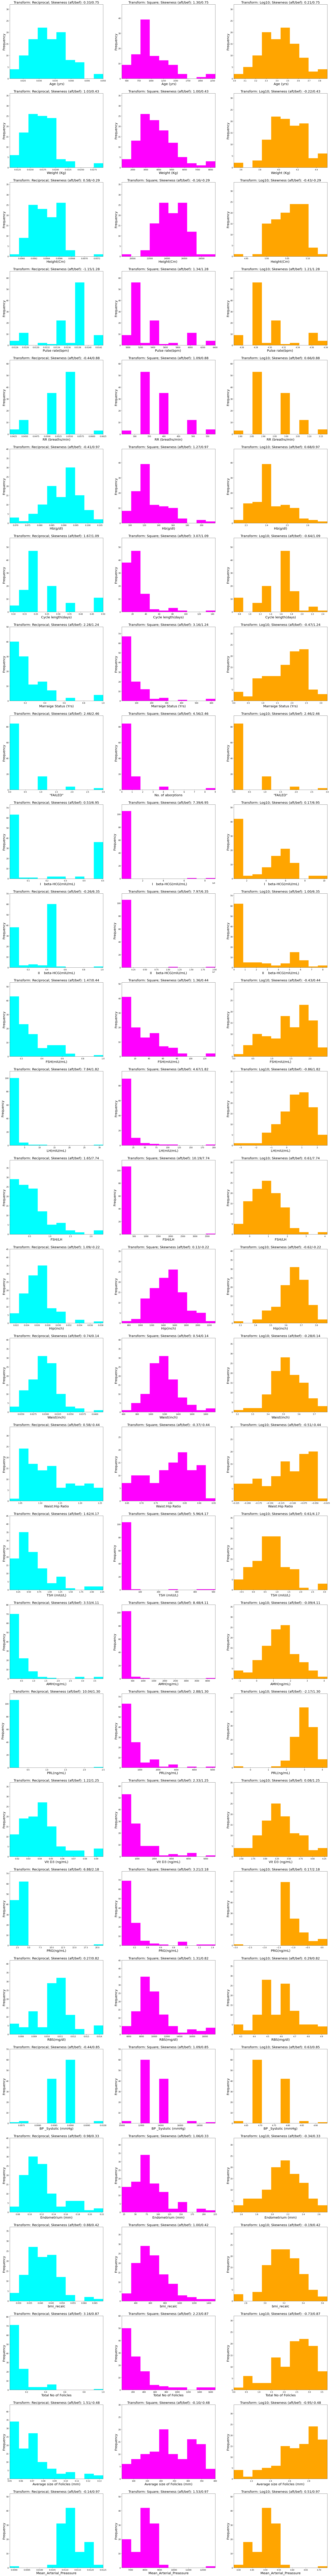

Working on  Age (yrs) feature
Working on Weight (Kg) feature
Working on Height(Cm)  feature
Working on Pulse rate(bpm)  feature
Working on RR (breaths/min) feature
Working on Hb(g/dl) feature
Working on Cycle length(days) feature
Working on Marraige Status (Yrs) feature
Working on No. of aborptions feature
--> Oops! It seems a 1/0 division got in the way.
--> Oops! It seems a log10(0) got in the way.
Working on   I   beta-HCG(mIU/mL) feature
Working on II    beta-HCG(mIU/mL) feature
Working on FSH(mIU/mL) feature
Working on LH(mIU/mL) feature
Working on FSH/LH feature
Working on Hip(inch) feature
Working on Waist(inch) feature
Working on Waist:Hip Ratio feature
Working on TSH (mIU/L) feature
Working on AMH(ng/mL) feature
Working on PRL(ng/mL) feature
Working on Vit D3 (ng/mL) feature
Working on PRG(ng/mL) feature
Working on RBS(mg/dl) feature
Working on BP _Systolic (mmHg) feature
Working on Endometrium (mm) feature
--> Oops! It seems a 1/0 division got in the way.
--> Oops! It seems a

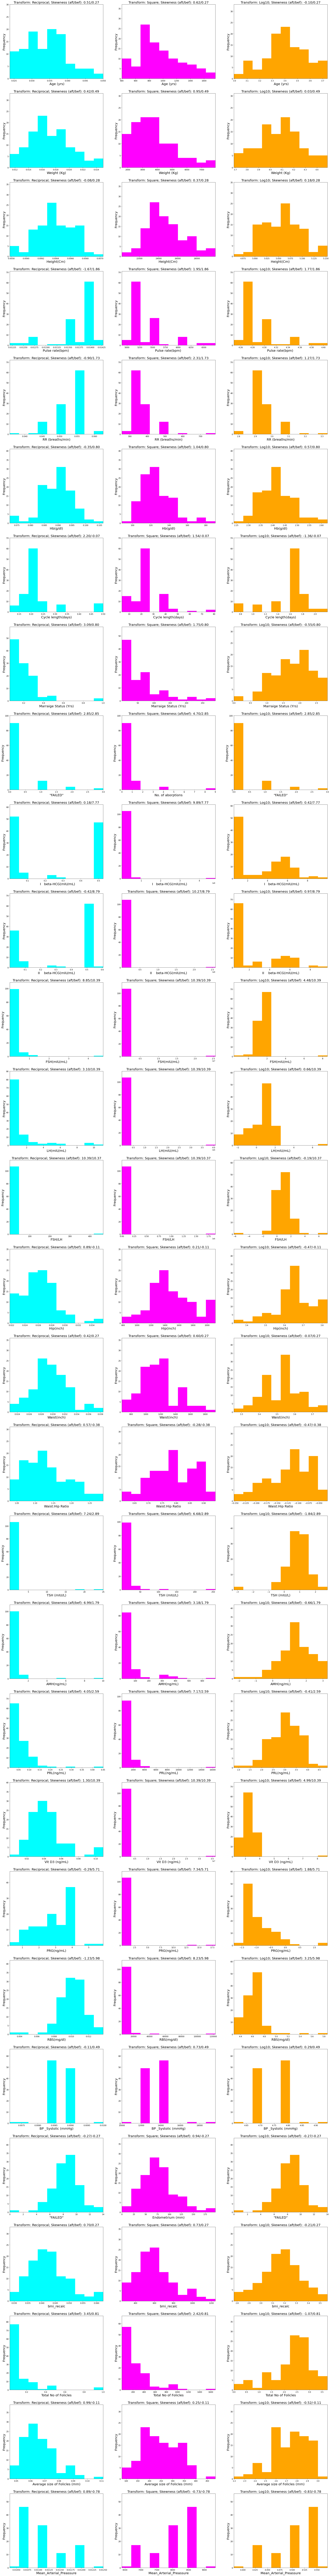

In [ ]:
# Apply skewness mitigation on selected features.
# Override feature columns
colors = ["cyan", "magenta", "orange"]
skew_atens = [get_recip, get_sqr, get_log]
type_trans = ["Reciprocal", "Square", "Log10"]
skew_atens_dict = {"Reciprocal": get_recip, "Square": get_sqr, "Log10":get_log}

for X_data in X_data_list:
  best_transform = get_best_skew(numeric_feats=features_numeric, x_data=X_data, \
                skew_atens=skew_atens, colors=colors)
  for item in best_transform.items():
    feature, method = item[0], item[1]
    X_data[feature] = X_data[feature].apply(skew_atens_dict[method])

Text(0.5, 0, 'Average Size of Folicles (mm)')

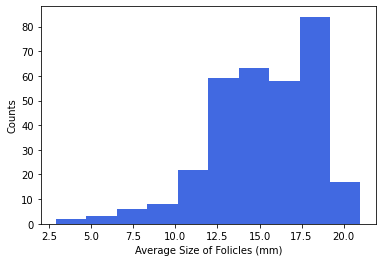

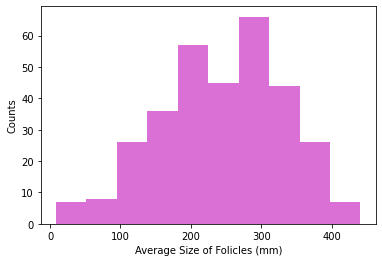

In [ ]:
fig, ax = plt.subplots()
ax.hist(_X_train_avfollicle, color="royalblue")
ax.set_ylabel("Counts")
ax.set_xlabel("Average Size of Folicles (mm)")
fig, ax = plt.subplots()
ax.hist(X_train["Average size of Folicles (mm)"], color="orchid")
ax.set_ylabel("Counts")
ax.set_xlabel("Average Size of Folicles (mm)")

### **<-------------- Lines above will include skewness**

In [ ]:
# Final check
for X_data in X_data_list:
  print(f"\nTotal of null values: {X_data.isnull().sum().sum()}\n")
  print(f"dtypes for all columns:\n{X_data.dtypes}")


Total of null values: 0

dtypes for all columns:
 Age (yrs)                       float64
Weight (Kg)                      float64
Height(Cm)                       float64
Pulse rate(bpm)                  float64
RR (breaths/min)                 float64
Hb(g/dl)                         float64
Cycle length(days)               float64
Marraige Status (Yrs)            float64
Pregnant(Y/N)                    float64
No. of aborptions                float64
  I   beta-HCG(mIU/mL)           float64
II    beta-HCG(mIU/mL)           float64
FSH(mIU/mL)                      float64
LH(mIU/mL)                       float64
FSH/LH                           float64
Hip(inch)                        float64
Waist(inch)                      float64
Waist:Hip Ratio                  float64
TSH (mIU/L)                      float64
AMH(ng/mL)                       float64
PRL(ng/mL)                       float64
Vit D3 (ng/mL)                   float64
PRG(ng/mL)                       float64
RBS(mg/

In [ ]:
# Display features names
display(features_categ)
display(features_numeric)
print(f"Features total: {len(features_all)}")

['Pregnant(Y/N)',
 'Weight gain(Y/N)',
 'hair growth(Y/N)',
 'Skin darkening (Y/N)',
 'Hair loss(Y/N)',
 'Pimples(Y/N)',
 'Fast food (Y/N)',
 'Reg.Exercise(Y/N)',
 'BP _Diastolic (mmHg)',
 'enc_blood_group_11.0',
 'enc_blood_group_12.0',
 'enc_blood_group_13.0',
 'enc_blood_group_14.0',
 'enc_blood_group_15.0',
 'enc_blood_group_16.0',
 'enc_blood_group_17.0',
 'enc_blood_group_18.0',
 'enc_cycle(r/i)_2.0',
 'enc_cycle(r/i)_4.0',
 'enc_cycle(r/i)_5.0',
 'obesity_(y/n)']

[' Age (yrs)',
 'Weight (Kg)',
 'Height(Cm) ',
 'Pulse rate(bpm) ',
 'RR (breaths/min)',
 'Hb(g/dl)',
 'Cycle length(days)',
 'Marraige Status (Yrs)',
 'No. of aborptions',
 '  I   beta-HCG(mIU/mL)',
 'II    beta-HCG(mIU/mL)',
 'FSH(mIU/mL)',
 'LH(mIU/mL)',
 'FSH/LH',
 'Hip(inch)',
 'Waist(inch)',
 'Waist:Hip Ratio',
 'TSH (mIU/L)',
 'AMH(ng/mL)',
 'PRL(ng/mL)',
 'Vit D3 (ng/mL)',
 'PRG(ng/mL)',
 'RBS(mg/dl)',
 'BP _Systolic (mmHg)',
 'Endometrium (mm)',
 'bmi_recalc',
 'Total No of Folicles',
 'Average size of Folicles (mm)',
 'Mean_Arterial_Preassure']

Features total: 50


## **Scale Numerical Features**

In [ ]:
# Apply min-max scaling

X_train_minmax, X_val_minmax, X_test_minmax = X_train.copy(), X_val.copy(), X_test.copy()
#X_train_standard, X_test_standard = X_train.copy(), X_test.copy()

def get_minmax_scaled(df, feature, scaler_type):
  scaler = scaler_type()
  feature_scaled = scaler.fit_transform(df[[feature]].values)
  feature_scaled = (2 * feature_scaled) - 1
  df[feature] = feature_scaled
  return df

for feature in features_numeric:
  get_minmax_scaled(X_train_minmax, feature, MinMaxScaler)
  get_minmax_scaled(X_val_minmax, feature, MinMaxScaler)
  get_minmax_scaled(X_test_minmax, feature, MinMaxScaler)

## **Feature selection using Lasso regularizer**

In [ ]:
def print_results(results):
    print('Best Params: {}\n'.format(results.best_params_))

In [ ]:
# Get features w/coefficients != 0
# Define function to get non-zero features. 
def get_nonzero_features(X_train, y_train, X_val, y_val, init_alpha=1e-4, alpha_step=1.1, top_features=10):
  """Adapted from class laboratories.
  
  A function to obtain the top number of  non-zero features.
  X: a pandas DataFrame
  y: a pandas DataFrame
  returns top_features: a reduced list of features of X. 
  """
  alpha = init_alpha
  num_non_zero_weights = len(X_train.columns)
  while num_non_zero_weights > top_features:
    lasso_regressor = Lasso(alpha=alpha, max_iter=10000)
    lasso_regressor.fit(X_train, y_train)
    yhat = lasso_regressor.predict(X_val)
    mae = mean_absolute_error(y_val, yhat)
    mse = mean_squared_error(y_val, yhat)
    num_non_zero_weights = (lasso_regressor.coef_ != 0).sum()
    text = "Reg. coeff. (alpha): {:.4f} *** No. non-zero weights: {} *** "
    text += "MAE: {:.2f} *** MSE: {:.2f}"
    print(text.format(alpha, num_non_zero_weights, mae, mse))

    alpha *= alpha_step

  top_features = np.where(lasso_regressor.coef_ != 0)[0]
  
  full_features = X_train.columns
  top_features = list(full_features[top_features])

  return top_features

# Get features
top_features = get_nonzero_features(X_train_minmax, y_train, X_val_minmax, y_val,\
                                    init_alpha=1e-4, alpha_step=1.1, top_features=20)

print(f"\nFeatures w/non-zero coefficients:\n{top_features}")

Reg. coeff. (alpha): 0.0001 *** No. non-zero weights: 46 *** MAE: 0.35 *** MSE: 0.18
Reg. coeff. (alpha): 0.0001 *** No. non-zero weights: 46 *** MAE: 0.37 *** MSE: 0.19
Reg. coeff. (alpha): 0.0001 *** No. non-zero weights: 47 *** MAE: 0.38 *** MSE: 0.20
Reg. coeff. (alpha): 0.0001 *** No. non-zero weights: 47 *** MAE: 0.38 *** MSE: 0.20
Reg. coeff. (alpha): 0.0001 *** No. non-zero weights: 47 *** MAE: 0.38 *** MSE: 0.20
Reg. coeff. (alpha): 0.0002 *** No. non-zero weights: 45 *** MAE: 0.39 *** MSE: 0.21
Reg. coeff. (alpha): 0.0002 *** No. non-zero weights: 44 *** MAE: 0.39 *** MSE: 0.21
Reg. coeff. (alpha): 0.0002 *** No. non-zero weights: 44 *** MAE: 0.39 *** MSE: 0.21
Reg. coeff. (alpha): 0.0002 *** No. non-zero weights: 45 *** MAE: 0.38 *** MSE: 0.20
Reg. coeff. (alpha): 0.0002 *** No. non-zero weights: 44 *** MAE: 0.38 *** MSE: 0.20
Reg. coeff. (alpha): 0.0003 *** No. non-zero weights: 45 *** MAE: 0.39 *** MSE: 0.21
Reg. coeff. (alpha): 0.0003 *** No. non-zero weights: 43 *** MAE:

## **Redefine train, val, and test sets using `top_features`**

In [ ]:
X_train_minmax, X_val_minmax, X_test_minmax = X_train_minmax[top_features], X_val_minmax[top_features], X_test_minmax[top_features]

In [ ]:
# Get total number of instances after data cleaning
PCOS.shape

(537, 51)

##**Hyperparameter Tuning** 

In [ ]:
#KNeighborsClassifier
#n_neighbors=n_neighbors, weights=weights
KNN_model = KNeighborsClassifier()

parameters = {
    'n_neighbors': [5,11,15],
    'weights': ['uniform', 'distance']
}

cv_KNN_model = GridSearchCV(KNN_model, parameters, cv=5)
cv_KNN_model.fit(X_train_minmax, y_train.values.ravel())

print_results(cv_KNN_model)

Best Params: {'n_neighbors': 5, 'weights': 'uniform'}



In [ ]:
#Write out pickled best model for KNeighborsClassifier
joblib.dump(cv_KNN_model.best_estimator_, 'KNN_model.pkl')

['KNN_model.pkl']

In [ ]:
#Decision Tree

DTC_model = DecisionTreeClassifier()

parameters = {
    'criterion': ["gini", "entropy"],
    'splitter': ["best", "random"],
    'min_samples_split': [1., 2],
    'min_samples_leaf': [1, 2],
    'max_depth': [4,8]
}
cv_DTC_model = GridSearchCV(DTC_model, parameters, cv=5)
cv_DTC_model.fit(X_train_minmax, y_train.values.ravel())

print_results(cv_DTC_model)

Best Params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}



In [ ]:
#Write out pickled best model for DecisionTreeClassifier
joblib.dump(cv_DTC_model.best_estimator_, 'DTM_model.pkl')

['DTM_model.pkl']

In [ ]:
#Random Forest
RF_model = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 250, 500],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv_RF_model = GridSearchCV(RF_model, parameters, cv=5)
cv_RF_model.fit(X_train_minmax, y_train.values.ravel())

print_results(cv_RF_model)

Best Params: {'max_depth': 32, 'n_estimators': 500}



In [ ]:
#Write out pickled best model for RandomForestClassifier
joblib.dump(cv_RF_model.best_estimator_, 'RF_model.pkl')

['RF_model.pkl']

In [ ]:
#XGBoost
XGBC_model = XGBClassifier()
parameters = {
    'n_estimators': [5, 50, 250, 500],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

cv_XGBC_model = GridSearchCV(XGBC_model, parameters, cv=5)
cv_XGBC_model.fit(X_train_minmax, y_train.values.ravel())

print_results(cv_XGBC_model)

Best Params: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 5}



In [ ]:
#Write out pickled best model for RandomForestClassifier
joblib.dump(cv_XGBC_model.best_estimator_, 'XGBC_model.pkl')

['XGBC_model.pkl']

In [ ]:
#Logistic Regression
LR_model = LogisticRegression(max_iter=100000)

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

cv_LR_model = GridSearchCV(LR_model, parameters, cv=5)
cv_LR_model.fit(X_train_minmax, y_train.values.ravel())

print_results(cv_LR_model)

Best Params: {'C': 100}



In [ ]:
#Write out pickled best model for Logistic Regression
joblib.dump(cv_LR_model.best_estimator_, 'LR_model.pkl')

['LR_model.pkl']

In [ ]:
#Support Vector Classifier
SVC_model = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}
cv_SVC_model = GridSearchCV(SVC_model, parameters, cv=5)
cv_SVC_model.fit(X_train_minmax, y_train.values.ravel())

print_results(cv_SVC_model)

Best Params: {'C': 0.1, 'kernel': 'linear'}



In [ ]:
#Write out pickled best model for Support Vector Classifier
joblib.dump(cv_SVC_model.best_estimator_, 'SVC_model.pkl')

['SVC_model.pkl']

In [ ]:
models = {}

for mdl in ['KNN', 'DTM', 'RF', 'XGBC', 'LR', 'SVC']:
    models[mdl] = joblib.load('{}_model.pkl'.format(mdl))
models 

{'KNN': KNeighborsClassifier(),
 'DTM': DecisionTreeClassifier(criterion='entropy', max_depth=8, splitter='random'),
 'RF': RandomForestClassifier(max_depth=16, n_estimators=500),
 'XGBC': XGBClassifier(learning_rate=1, missing=nan, n_estimators=5),
 'LR': LogisticRegression(C=100, max_iter=100000),
 'SVC': SVC(C=0.1, kernel='linear')}

##**Evaluate models (w/best set of hyperparms) on the validation set**

In [ ]:
Model_performance = []
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    f1score = round(f1_score(labels, pred), 3)
    aucs = round(roc_auc_score(labels, pred), 3)
    Model_performance.append({'Model': name,
                      'Accuracy': accuracy,
                      'Precision': precision,
                      'Recall': recall,
                      'F1 Score': f1score,
                      'AUC': aucs,
                      'Latency': round((end - start)*1000, 1)
                      })
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / F1 Score: {} / AUC: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   f1score,
                                                                                   aucs,          
                                                                                   round((end - start)*1000, 1)))

In [ ]:
for name, mdl in models.items():
    evaluate_model(name, mdl, X_val_minmax, y_val)
summary_MLmodels = pd.DataFrame(Model_performance)
summary_MLmodels

KNN -- Accuracy: 0.925 / Precision: 0.947 / Recall: 0.857 / F1 Score: 0.9 / AUC: 0.913 / Latency: 17.7ms
DTM -- Accuracy: 0.916 / Precision: 0.884 / Recall: 0.905 / F1 Score: 0.894 / AUC: 0.914 / Latency: 2.7ms
RF -- Accuracy: 0.944 / Precision: 0.95 / Recall: 0.905 / F1 Score: 0.927 / AUC: 0.937 / Latency: 102.2ms
XGBC -- Accuracy: 0.897 / Precision: 0.919 / Recall: 0.81 / F1 Score: 0.861 / AUC: 0.882 / Latency: 2.5ms
LR -- Accuracy: 0.963 / Precision: 0.952 / Recall: 0.952 / F1 Score: 0.952 / AUC: 0.961 / Latency: 1.9ms
SVC -- Accuracy: 0.944 / Precision: 0.95 / Recall: 0.905 / F1 Score: 0.927 / AUC: 0.937 / Latency: 3.0ms


Model  Accuracy  Precision  Recall  F1 Score    AUC  Latency
0   KNN     0.925      0.947   0.857     0.900  0.913     17.7
1   DTM     0.916      0.884   0.905     0.894  0.914      2.7
2    RF     0.944      0.950   0.905     0.927  0.937    102.2
3  XGBC     0.897      0.919   0.810     0.861  0.882      2.5
4    LR     0.963      0.952   0.952     0.952  0.961      1.9
5   SVC     0.944      0.950   0.905     0.927  0.937      3.0

In [ ]:
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC',
       'Latency']
for feature in metrics_list:
  fig = px.bar(summary_MLmodels,
             y=feature,
             x='Model',
             text_auto=True,
             color=feature,
             color_continuous_scale = "darkmint")
  fig.update_xaxes(categoryorder='total ascending')
  #fig.update_traces(marker_color='orange')
  fig.update_traces(textfont_size=50,
                  marker=dict(line=dict(width=2)))
  fig.update_layout(yaxis = dict(tickfont = dict(size=25)))
  fig.update_layout(xaxis = dict(tickfont = dict(size=60)))
  fig.update_xaxes(
        title_font = {"size": 20})
  fig.update_yaxes(
        title_font = {"size": 70})
  fig.show()

### **Scores before transforming skewness**
|  KNN | -- | Accuracy: | 0.897 | / | Precision: | 0.97  | / | Recall: | 0.762 | / | F1 | Score: | 0.853 | / | AUC: | 0.873 | / | Latency: | 17.6ms |
|:----:|:--:|:---------:|-------|---|------------|-------|---|---------|-------|---|----|--------|-------|---|------|-------|---|----------|--------|
|  DTM | -- | Accuracy: | 0.86  | / | Precision: | 0.865 | / | Recall: | 0.762 | / | F1 | Score: | 0.81  | / | AUC: | 0.842 | / | Latency: | 2.8ms  |
|  RF  | -- | Accuracy: | 0.907 | / | Precision: | 0.971 | / | Recall: | 0.786 | / | F1 | Score: | 0.868 | / | AUC: | 0.885 | / | Latency: | 58.0ms |
| XGBC | -- | Accuracy: | 0.944 | / | Precision: | 0.95  | / | Recall: | 0.905 | / | F1 | Score: | 0.927 | / | AUC: | 0.937 | / | Latency: | 6.9ms  |
|  LR  | -- | Accuracy: | 0.944 | / | Precision: | 0.95  | / | Recall: | 0.905 | / | F1 | Score: | 0.927 | / | AUC: | 0.937 | / | Latency: | 3.2ms  |
|  SVC | -- | Accuracy: | 0.944 | / | Precision: | 0.95  | / | Recall: | 0.905 | / | F1 | Score: | 0.927 | / | AUC: | 0.937 | / | Latency: | 5.3ms  |

### **Scores after transforming skewness**
|  KNN | -- | Accuracy: | 0.888 | / | Precision: | 0.857 | / | Recall: | 0.857 | / | F1 | Score: | 0.857 | / | AUC: | 0.882 | / | Latency: | 16.6ms |
|:----:|:--:|:---------:|-------|---|------------|-------|---|---------|-------|---|----|--------|-------|---|------|-------|---|----------|--------|
|  DTM | -- | Accuracy: | 0.841 | / | Precision: | 0.745 | / | Recall: | 0.905 | / | F1 | Score: | 0.817 | / | AUC: | 0.852 | / | Latency: | 3.8ms  |
|  RF  | -- | Accuracy: | 0.879 | / | Precision: | 0.796 | / | Recall: | 0.929 | / | F1 | Score: | 0.857 | / | AUC: | 0.887 | / | Latency: | 52.4ms |
| XGBC | -- | Accuracy: | 0.71  | / | Precision: | 0.582 | / | Recall: | 0.929 | / | F1 | Score: | 0.716 | / | AUC: | 0.749 | / | Latency: | 5.5ms  |
|  LR  | -- | Accuracy: | 0.85  | / | Precision: | 0.732 | / | Recall: | 0.976 | / | F1 | Score: | 0.837 | / | AUC: | 0.873 | / | Latency: | 2.5ms  |
|  SVC | -- | Accuracy: | 0.832 | / | Precision: | 0.714 | / | Recall: | 0.952 | / | F1 | Score: | 0.816 | / | AUC: | 0.853 | / | Latency: | 3.3ms  |

### **Scores after features space reduction using Lasso regularizer**

|  KNN | -- | Accuracy: | 0.87  | / | Precision: | 0.889 | / | Recall: | 0.762 | / | F1 | Score: | 0.821 | / | AUC: | 0.851 | / | Latency: | 14.2ms |
|:----:|:--:|:---------:|-------|---|------------|-------|---|---------|-------|---|----|--------|-------|---|------|-------|---|----------|--------|
|  DTM | -- | Accuracy: | 0.926 | / | Precision: | 0.947 | / | Recall: | 0.857 | / | F1 | Score: | 0.9   | / | AUC: | 0.913 | / | Latency: | 2.2ms  |
|  RF  | -- | Accuracy: | 0.926 | / | Precision: | 0.905 | / | Recall: | 0.905 | / | F1 | Score: | 0.905 | / | AUC: | 0.922 | / | Latency: | 54.9ms |
| XGBC | -- | Accuracy: | 0.907 | / | Precision: | 0.864 | / | Recall: | 0.905 | / | F1 | Score: | 0.884 | / | AUC: | 0.907 | / | Latency: | 3.3ms  |
|  LR  | -- | Accuracy: | 0.889 | / | Precision: | 0.895 | / | Recall: | 0.81  | / | F1 | Score: | 0.85  | / | AUC: | 0.874 | / | Latency: | 2.2ms  |
|  SVC | -- | Accuracy: | 0.87  | / | Precision: | 0.889 | / | Recall: | 0.762 | / | F1 | Score: | 0.821 | / | AUC: | 0.851 | / | Latency: | 3.0ms  |

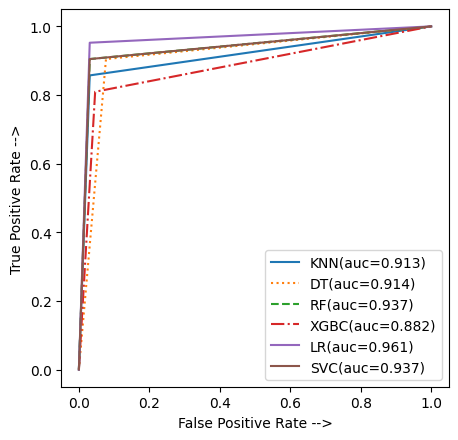

In [ ]:
#Plot Area under the curve
KNN_M = joblib.load('KNN_model.pkl')
pred_KNN_M= KNN_M.predict(X_val_minmax)
KNN_M_fpr, KNN_M_tpr, threshold = roc_curve(y_val, pred_KNN_M)
auc_KNN = auc(KNN_M_fpr, KNN_M_tpr)

DT_M = joblib.load('DTM_model.pkl')
pred_DT_M = DT_M.predict(X_val_minmax)
DT_M_fpr, DT_M_tpr, threshold = roc_curve(y_val, pred_DT_M)
auc_DT = auc(DT_M_fpr, DT_M_tpr)

RF_M = joblib.load('RF_model.pkl')
pred_RF_M = RF_M.predict(X_val_minmax)
RF_M_fpr, RF_M_tpr, threshold = roc_curve(y_val, pred_RF_M)
auc_RF = auc(RF_M_fpr, RF_M_tpr)

XGBC_M = joblib.load('XGBC_model.pkl')
pred_XGBC_M = XGBC_M.predict(X_val_minmax)
XGBC_M_fpr, XGBC_M_tpr, threshold = roc_curve(y_val, pred_XGBC_M)
auc_XGBC = auc(XGBC_M_fpr, XGBC_M_tpr)

LR_M = joblib.load('LR_model.pkl')
pred_LR_M = LR_M.predict(X_val_minmax)
LR_M_fpr, LR_M_tpr, threshold = roc_curve(y_val, pred_LR_M)
auc_LR = auc(LR_M_fpr, LR_M_tpr)

SVC_M = joblib.load('SVC_model.pkl')
pred_SVC_M = SVC_M.predict(X_val_minmax)
SVC_M_fpr, SVC_M_tpr, threshold = roc_curve(y_val, pred_SVC_M)
auc_SVC = auc(SVC_M_fpr, SVC_M_tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(KNN_M_fpr, KNN_M_tpr, linestyle='-', label='KNN(auc=%0.3f)' % auc_KNN)
plt.plot(DT_M_fpr, DT_M_tpr, linestyle=':', label='DT(auc=%0.3f)' % auc_DT)
plt.plot(RF_M_fpr, RF_M_tpr, linestyle='--', label='RF(auc=%0.3f)' % auc_RF)
plt.plot(XGBC_M_fpr, XGBC_M_tpr, linestyle='-.', label='XGBC(auc=%0.3f)' % auc_XGBC)
plt.plot(LR_M_fpr, LR_M_tpr, linestyle='solid', label='LR(auc=%0.3f)' % auc_LR)
plt.plot(SVC_M_fpr, SVC_M_tpr, linestyle='solid', label='SVC(auc=%0.3f)' % auc_SVC)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

In [ ]:
stop

## **Evaluate best models on test set**

In [ ]:
Best_models = {}
#for bestmdl in ['XGBC', 'DTM', 'RF']:
#for bestmdl in ['KNN', 'DTM', 'RF', 'XGBC', 'LR', 'SVC']:
for bestmdl in ['LR']:
    Best_models[bestmdl] = joblib.load('{}_model.pkl'.format(bestmdl))
Best_models 

{'LR': LogisticRegression(C=100, max_iter=100000)}

In [ ]:
Model_performance_best = []
def evaluate_modelBest(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    f1score = round(f1_score(labels, pred), 3)
    aucs = round(roc_auc_score(labels, pred), 3)
    Model_performance_best.append({'Model': name,
                      'Accuracy': accuracy,
                      'Precision': precision,
                      'Recall': recall,
                      'F1 Score': f1score,
                      'AUC': aucs,
                      'Latency': round((end - start)*1000, 1)
                      })
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / F1 Score: {} / AUC: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   f1score,
                                                                                   aucs,          
                                                                                   round((end - start)*1000, 1)))

In [ ]:
for name, bestmdl in Best_models.items():
    evaluate_modelBest(name, bestmdl, X_test_minmax, y_test)
summary_BestMLmodels = pd.DataFrame(Model_performance_best)
summary_BestMLmodels

LR -- Accuracy: 0.852 / Precision: 0.893 / Recall: 0.658 / F1 Score: 0.758 / AUC: 0.808 / Latency: 7.6ms


Model  Accuracy  Precision  Recall  F1 Score    AUC  Latency
0    LR     0.852      0.893   0.658     0.758  0.808      7.6

In [ ]:
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC',
       'Latency']
for feature in metrics_list:
  fig = px.bar(summary_BestMLmodels,
             y=feature,
             x='Model',
             text_auto=True,
             color=feature,
             color_continuous_scale = "darkmint")
  fig.update_xaxes(categoryorder='total ascending')
  #fig.update_traces(marker_color='orange')
  fig.update_traces(textfont_size=50,
                  marker=dict(line=dict(width=2)))
  fig.update_layout(yaxis = dict(tickfont = dict(size=25)))
  fig.update_layout(xaxis = dict(tickfont = dict(size=60)))
  fig.update_xaxes(
        title_font = {"size": 20})
  fig.update_yaxes(
        title_font = {"size": 70})
  fig.show()

In [ ]:
fig = px.bar(summary_BestMLmodels,
             y=['Precision', 'Accuracy', 'F1 Score', 'Recall'],
             x='Model',
             text_auto=True,
             barmode='group')
             #color=feature,
             #color_continuous_scale = "darkmint")
#fig.update_xaxes(categoryorder='array', categoryarray= ['Recall', 'F1 Score', 'Accuracy', 'Precision'])
#fig.update_xaxes(categoryorder='total descending')
#fig.update_layout(barmode='group', xaxis={'categoryorder':'total descending'})
#fig.update_traces(marker_color='orange')
fig.update_traces(textfont_size=50,
                  marker=dict(line=dict(width=2)))
fig.update_layout(yaxis = dict(tickfont = dict(size=25)))
fig.update_layout(xaxis = dict(tickfont = dict(size=60)))
fig.update_xaxes(
        title_font = {"size": 20})
fig.update_yaxes(
        title_font = {"size": 70})
fig.update_layout(
    font=dict(
        size=40,  # Set the font size here
    )
)
fig.show()

In [ ]:
stop

KNN
DTM
RF
XGBC
LR
SVC


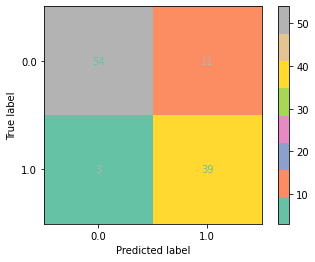

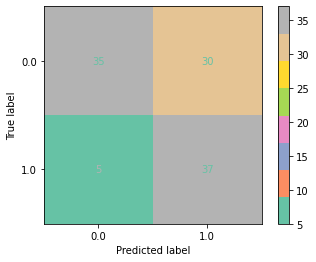

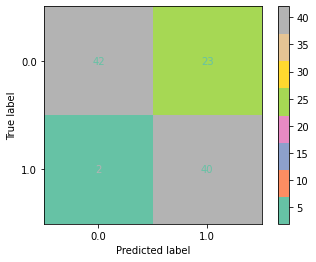

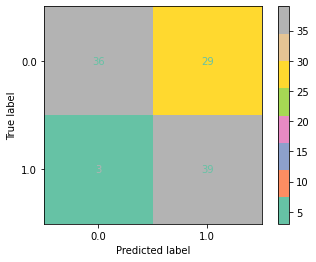

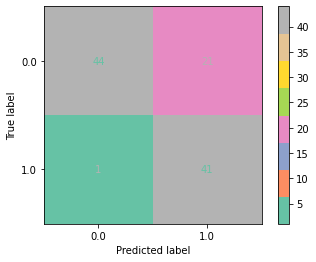

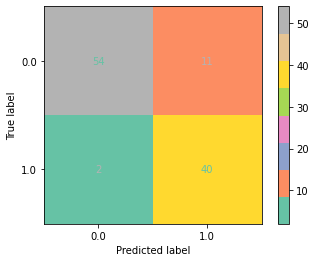

In [ ]:
for name, mdl in Best_models.items(): 
  print(name)
  ConfusionMatrixDisplay.from_estimator(mdl, X_val_minmax, y_val, cmap="Set2")

## **Using test set**
### **Scores before transforming skewness**
| XGBC | -- | Accuracy: | 0.88  | / | Precision: | 0.838 | / | Recall: | 0.816 | / | F1 | Score: | 0.827 | / | AUC: | 0.865 | / | Latency: | 5.9ms |
|:----:|:--:|:---------:|-------|---|------------|-------|---|---------|-------|---|----|--------|-------|---|------|-------|---|----------|-------|
|  LR  | -- | Accuracy: | 0.852 | / | Precision: | 0.923 | / | Recall: | 0.632 | / | F1 | Score: | 0.75  | / | AUC: | 0.802 | / | Latency: | 3.1ms |
|  SVC | -- | Accuracy: | 0.833 | / | Precision: | 0.857 | / | Recall: | 0.632 | / | F1 | Score: | 0.727 | / | AUC: | 0.787 | / | Latency: | 2.4ms |


### **Scores after transforming skewness**
| XGBC | -- | Accuracy: | 0.889 | / | Precision: | 0.882 | / | Recall: | 0.789 | / | F1 | Score: | 0.833 | / | AUC: | 0.866 | / | Latency: | 8.3ms |
|:----:|:--:|:---------:|-------|---|------------|-------|---|---------|-------|---|----|--------|-------|---|------|-------|---|----------|-------|
|  LR  | -- | Accuracy: | 0.824 | / | Precision: | 0.852 | / | Recall: | 0.605 | / | F1 | Score: | 0.708 | / | AUC: | 0.774 | / | Latency: | 2.0ms |
|  SVC | -- | Accuracy: | 0.833 | / | Precision: | 0.857 | / | Recall: | 0.632 | / | F1 | Score: | 0.727 | / | AUC: | 0.787 | / | Latency: | 2.5ms |

### **Scores after features space reduction using Lasso regularizer**
| XGBC | -- | Accuracy: | 0.704 | / | Precision: | 0.429 | / | Recall: | 0.692 | / | F1 | Score: | 0.529 | / | AUC: | 0.7  | / | Latency: | 4.5ms |
|:----:|:--:|:---------:|-------|---|------------|-------|---|---------|-------|---|----|--------|-------|---|------|------|---|----------|-------|
|  LR  | -- | Accuracy: | 0.741 | / | Precision: | 0.476 | / | Recall: | 0.769 | / | F1 | Score: | 0.588 | / | AUC: | 0.75 | / | Latency: | 1.8ms |
|  SVC | -- | Accuracy: | 0.741 | / | Precision: | 0.476 | / | Recall: | 0.769 | / | F1 | Score: | 0.588 | / | AUC: | 0.75 | / | Latency: | 2.4ms |

### **Scores  w/o skewness correction and after features space reduction using Lasso regularizer**
| XGBC | -- | Accuracy: | 0.843 | / | Precision: | 0.818 | / | Recall: | 0.711 | / | F1 | Score: | 0.761 | / | AUC: | 0.812 | / | Latency: | 5.9ms |
|:----:|:--:|:---------:|-------|---|------------|-------|---|---------|-------|---|----|--------|-------|---|------|-------|---|----------|-------|
|  LR  | -- | Accuracy: | 0.852 | / | Precision: | 0.893 | / | Recall: | 0.658 | / | F1 | Score: | 0.758 | / | AUC: | 0.808 | / | Latency: | 3.2ms |
|  SVC | -- | Accuracy: | 0.833 | / | Precision: | 0.885 | / | Recall: | 0.605 | / | F1 | Score: | 0.719 | / | AUC: | 0.781 | / | Latency: | 3.9ms |

## **Feature importance with shaps using XGBC Model**

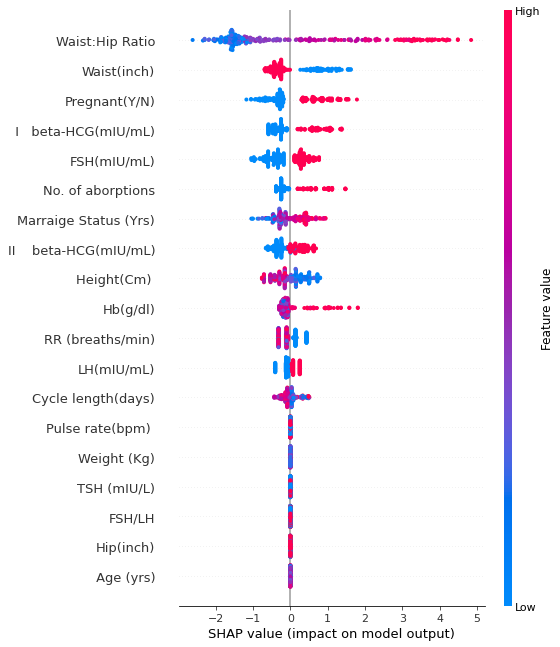

In [ ]:
#Create object that can calculate shap values
sh_explainer = shap.TreeExplainer(XGBC_M.fit(X_train_minmax, y_train))
#Calculate Shap values
shap_values = sh_explainer.shap_values(X_train_minmax)
#Summary Plot
shap.summary_plot(shap_values, X_train_minmax, feature_names=columns_names)

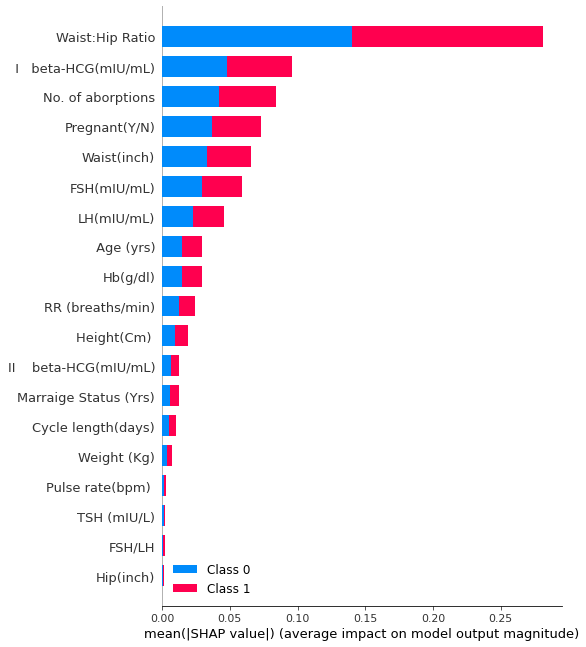

In [ ]:
#I will use the random forest model to see the feature importance RF_M
#Create object that can calculate shap values
sh_explainer = shap.TreeExplainer(RF_M)
#Calculate Shap values
shap_values = sh_explainer.shap_values(X_train_minmax)
#Summary Plot
shap.summary_plot(shap_values, X_train_minmax, feature_names=columns_names)